In [1]:
from multilevel_cutpoint_model import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from Node import Node

# Simulated data

## Bi-modal

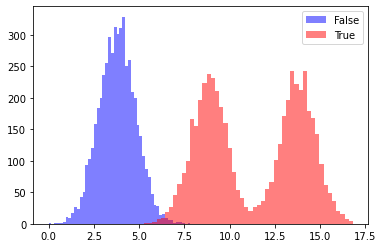

In [2]:
# shifted and scaled sigmoid function
def test_sigmoid(x, a=0, b=1.):
    return 1 / (1 + (np.exp(-1 * (x - a) / b)))

N = 10000
P = 5

rs = np.random.RandomState(1978)

X = rs.randn(N, P)
w = rs.randn(P)

y_prob = test_sigmoid(X @ w)
y = (rs.rand(N) < y_prob).astype(int)
t = (rs.randn(N) + 5 * y + (rs.rand(N)> 0.5) * 5 * y )

# make times positive
t += abs(min(t))

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="False")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="True")
plt.legend()
plt.show()

In [3]:
m = Model(X, t, depth = 1, cutpoint0=None, iterations = 1000)
m.train()

C:\Users\jimmy\anaconda3\lib\site-packages\torch\optim\adam.py:74: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


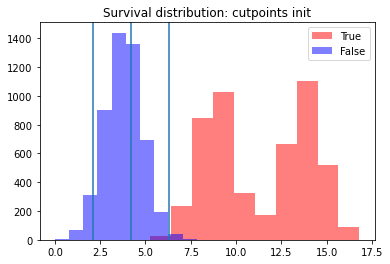

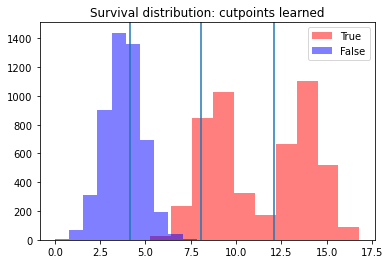

In [4]:
m.plot_result(t[y==1], t[y==0])

## more modes

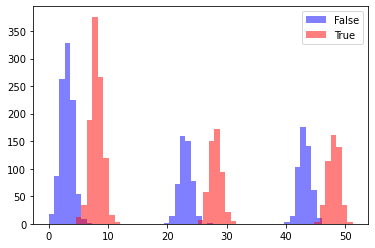

In [5]:
N = 1000
P = 5

rs = np.random.RandomState(1978)
# python please I want a do while loop

X = rs.randn(N, P)
w = rs.randn(P)

y_prob = test_sigmoid(X @ w)
y = (rs.rand(N) < y_prob).astype(int)
t = (rs.randn(N) + 5 * y )


for i in range(0, 3):
    X_i = rs.randn(N, P)
    w_i = rs.randn(P)

    y_prob = test_sigmoid(X_i @ w_i)
    y_i = (rs.rand(N) < y_prob).astype(int)
    t_i = (rs.randn(N) + 20 * i + 5 * y_i )
    X = np.concatenate((X, X_i))
    t = np.concatenate((t, t_i))
    y = np.concatenate((y, y_i))
    

# make times positive
t += abs(min(t))

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="False")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="True")
plt.legend()
plt.show()

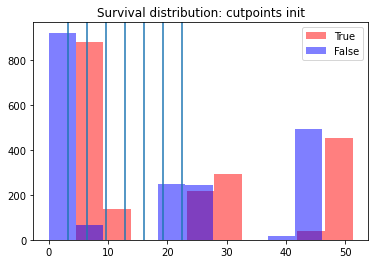

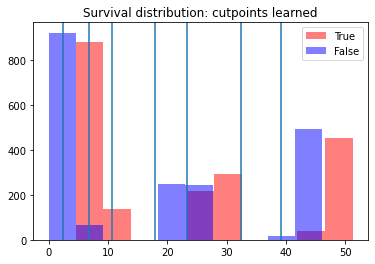

In [6]:
m = Model(X, t, depth = 2, iterations = 1000)
m.train()
m.plot_result(t[y==1], t[y==0])

# Sksurv data

## Breast Cancer

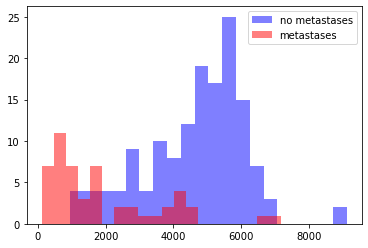

In [7]:
from sksurv.datasets import load_breast_cancer

data_x, data_y = load_breast_cancer()
y_df = pd.DataFrame.from_records(data_y)

# cut last covariates that are strings
X = torch.tensor(data_x.iloc[:, 1:-3].values)

t = torch.from_numpy(y_df["t.tdm"].values)


plt.hist(y_df[~y_df["e.tdm"]]["t.tdm"], bins = 20, alpha=0.5, color="blue", label="no metastases")
plt.hist(y_df[y_df["e.tdm"]]["t.tdm"], bins = 20, alpha=0.5, color="red", label="metastases")
plt.legend()

plt.show()

C:\Users\jimmy\home\git\Dynamic-Survival-Cutpoints\multilevel_cutpoint_model.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float)
C:\Users\jimmy\home\git\Dynamic-Survival-Cutpoints\multilevel_cutpoint_model.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t = torch.tensor(t, dtype=torch.float)
C:\Users\jimmy\anaconda3\lib\site-packages\torch\optim\adam.py:74: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


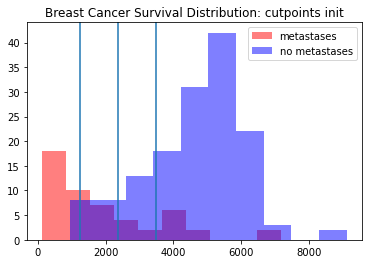

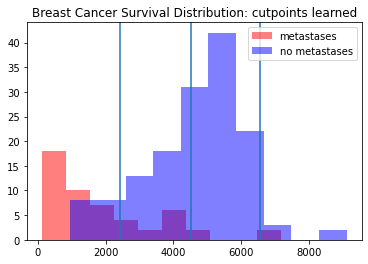

In [8]:
m = Model(X, t, depth = 1, iterations=1000)
m.train()
m.plot_result(y_df[y_df["e.tdm"]]["t.tdm"], 
              y_df[~y_df["e.tdm"]]["t.tdm"],
             title="Breast Cancer Survival Distribution",
             label_true="metastases",
             label_false="no metastases")

### Worcester Heart Attack Study

The dataset has 500 samples and 14 features. The endpoint is death, which occurred for 215 patients (43.0%).

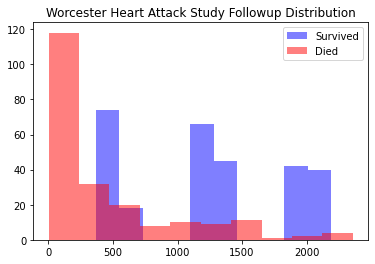

In [9]:
from sksurv.datasets import load_whas500

data_x, data_y = load_whas500()
y_df = pd.DataFrame.from_records(data_y)


X = torch.tensor(data_x[["age", "bmi", "diasbp", "hr", "los", "sysbp"]].values)

t = torch.from_numpy(y_df["lenfol"].values)
plt.title("Worcester Heart Attack Study Followup Distribution")
plt.hist(t[~y_df["fstat"].values], color="blue", alpha = 0.5, label="Survived")
plt.hist(t[y_df["fstat"].values], color="red", alpha = 0.5, label = "Died")
plt.legend()
plt.show()

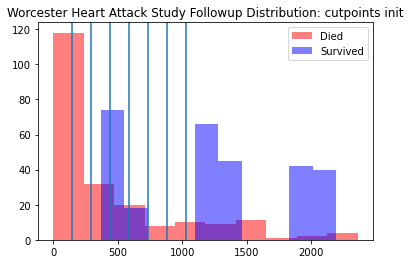

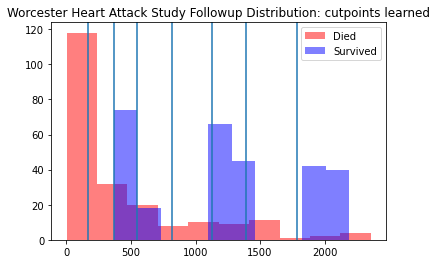

In [10]:
m = Model(X, t, depth = 2, iterations=1000)
m.train()
m.plot_result(t[y_df["fstat"].values], 
             t[~y_df["fstat"].values],
             title="Worcester Heart Attack Study Followup Distribution",
             label_true="Died",
             label_false="Survived")

# NACD Data

There are 51 features
There are 2402 patients


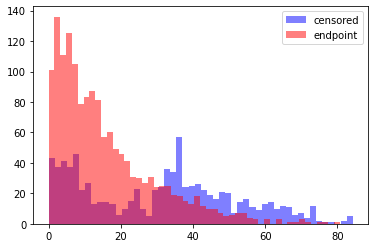

In [11]:
df= pd.read_csv('http://pssp.srv.ualberta.ca/system/predictors/datasets/000/000/032/original/All_Data_updated_may2011_CLEANED.csv?1350302245')
t = df["SURVIVAL"]
# make times positive
t += abs(min(t))

# censored: 1 is that they were censored 0 they experienced the event
y = 1 - df["CENSORED"]

numrc_cols = df.nunique() > 2
df.loc[:, numrc_cols] = (df.loc[:, numrc_cols] - df.loc[:, numrc_cols].mean()) / df.loc[:, numrc_cols].std()

OUTCOMES = ['SURVIVAL', 'CENSORED']
X = df.drop(OUTCOMES, axis=1).sample(frac=1, random_state=2021)
X = X.values

print('There are', X.shape[1], 'features')
print(f"There are {X.shape[0]} patients")

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="censored")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="endpoint")
plt.legend()
plt.show()

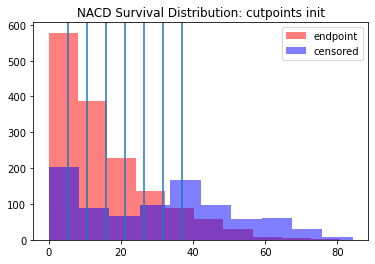

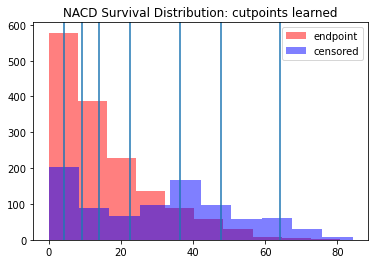

In [12]:
m = Model(X, t, depth = 2, iterations = 1000)
m.train()
m.plot_result(t[y==1],
              t[y==0],
              title="NACD Survival Distribution",
              label_true = "endpoint",
              label_false = "censored"
             )

# Support dataset

There are 61 features
There are 9105 patients


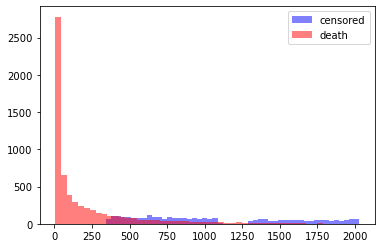

In [13]:
FILL_VALUES = {
    'alb': 3.5,
    'pafi': 333.3,
    'bili': 1.01,
    'crea': 1.01,
    'bun': 6.51,
    'wblc': 9.,
    'urine': 2502.
}

TO_DROP = ['aps', 'sps', 'surv2m', 'surv6m', 'prg2m', 'prg6m', 'dnr', 'dnrday']
TO_DROP = TO_DROP + ['sfdm2', 'hospdead']

# load, drop columns, fill using specified fill values
df = pd.read_csv('datasets/support2.csv').drop(TO_DROP,axis=1).fillna(value=FILL_VALUES)

# get dummies for categorical vars
df = pd.get_dummies(df, dummy_na=True)

# fill remaining values to the median

df = df.fillna(df.median())

# standardize numeric columns

numrc_cols = df.dtypes == 'float64'
df.loc[:, numrc_cols] = (df.loc[:, numrc_cols] - df.loc[:, numrc_cols].mean()) / df.loc[:, numrc_cols].std()

OUTCOMES = ['death', 'd.time']
X = df.drop(OUTCOMES, axis=1).sample(frac=1, random_state=2021)
X = X.values

t = df["d.time"]
y = df['death']

print('There are', X.shape[1], 'features')
print(f'There are {X.shape[0]} patients')

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="censored")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="death")
plt.legend()
plt.show()

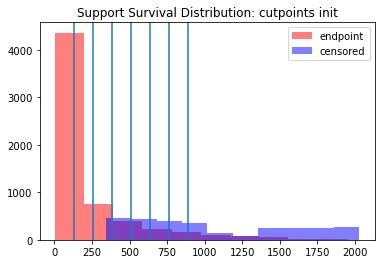

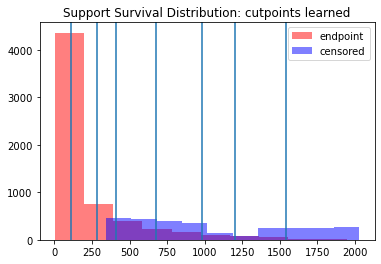

In [14]:
m = Model(X, t.values, depth = 2, iterations=1000)
m.train()
m.plot_result(t[y==1],
              t[y==0],
              title="Support Survival Distribution",
              label_true = "endpoint",
              label_false = "censored"
             )